### Imports 

In [1]:
import os

import numpy as np
import plotly.express as px
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

from data import PROJECT_ROOT_FOLDER, PROJECT_PROCESSED_DATA_FOLDER
from data_processing.data_loaders.raw_data_loaders import DataLoaders
from enums.EColor import EColor

### Configurations

In [2]:
full_graphs = False
release = False
x_log_scale = True
cities_data_date = '2022-01-29'
cases_signal = "Active_cases"  # {"Active_cases", "Cumulative_verified_cases"}
size_key = "population_5-19"
x_data_date = "29/1/22"
y_data_date = "29/1/22"
x_key = "{} per 10,000 people - {}".format(cases_signal.replace('_', ' '), x_data_date)
y_key = "Mortality[%]"
color_key = "VNR"
color_scale = [EColor.GREEN,
               EColor.ORANGE,
               EColor.RED]

### Raw data

In [3]:
# Cases data - x
cities_df_raw = DataLoaders.get_cases_by_city(temporal_analysis=False)

# Vaccination data - y
vaccination_df_raw = DataLoaders.get_vaccinations_by_age_and_city(temporal_analysis=False)

# Cases data for temporal analysis
temporal_cities_df_raw = DataLoaders.get_cases_by_city(temporal_analysis=True)

# Vaccination data for temporal analysis 
temporal_vaccination_df_raw = DataLoaders.get_vaccinations_by_age_and_city(temporal_analysis=True)

# Population data
pop_df_raw = DataLoaders.get_population_age_groups_by_city()

# Social-Economic Rank data
rank_df_raw = DataLoaders.get_socioeconomic_rank_by_city()

### Pre-Processing

#### Vaccinations by age and city data pre-processing

##### Raw Data

In [4]:
vaccination_df_raw

,CityName,CityCode,Date,first_dose_0-19,first_dose_20-29,first_dose_30-39,first_dose_40-49,first_dose_50-59,first_dose_60-69,first_dose_70-79,...,second_dose_90+,third_dose_0-19,third_dose_20-29,third_dose_30-39,third_dose_40-49,third_dose_50-59,third_dose_60-69,third_dose_70-79,third_dose_80-89,third_dose_90+
0,אבו ג'ווייעד (שבט),967,2020-12-20,0.0,0.0,0.0,<15,0.0,<15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,אבו ג'ווייעד (שבט),967,2020-12-21,0.0,0.0,<15,<15,<15,<15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,אבו ג'ווייעד (שבט),967,2020-12-22,0.0,0.0,<15,<15,<15,17.0,<15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,אבו ג'ווייעד (שבט),967,2020-12-23,0.0,0.0,<15,<15,<15,34.0,<15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,אבו ג'ווייעד (שבט),967,2020-12-24,0.0,<15,<15,<15,<15,54.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114081,תקוע,3563,2022-01-25,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114082,תקוע,3563,2022-01-26,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114083,תקוע,3563,2022-01-27,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114084,תקוע,3563,2022-01-28,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15


In [5]:
vaccination_df = vaccination_df_raw.copy()
vaccination_df["drop_row"] = False
for index, row in vaccination_df.iterrows():
#     cnt = int(row["60-69"] in ['< 15']) + \
#           int(row["70-79"] in ['< 15']) + \
#           int(row["80-89"] in ['< 15']) + \
#           int(row["90+"] in ['< 15'])
    cnt = int(row["first_dose_0-19"] in ['<15']) 
    if cnt > 1:
        vaccination_df.loc[index, "drop_row"] = True
vaccination_df = vaccination_df[vaccination_df.drop_row == False]
vaccination_df = vaccination_df.drop("drop_row", 1)
vaccination_df.rename(columns={"CityName": "City_Name"}, 
                              inplace=True)

vaccination_df.replace('<15', 1, inplace=True)
vaccination_df.replace(np.nan, -100, inplace=True)
vaccination_df.set_index('City_Name', inplace=True)
# vaccination_df = vaccination_df.astype('float').astype('int')
vaccination_df.replace(-100, np.nan, inplace=True)
vaccination_df.reset_index(inplace=True)

In [6]:
# Calculating 60+ vaccinations
# vaccination_df["vaccination_60+"] = vaccination_df["60-69"].fillna(0) + \
#                                     vaccination_df["70-79"].fillna(0) + \
#                                     vaccination_df["80-89"].fillna(0) + \
#                                     vaccination_df["90+"].fillna(0)
vaccination_df["vaccination_0-19"] = vaccination_df["first_dose_0-19"].fillna(0) 

##### Pre-processed data 

In [7]:
vaccination_df

,City_Name,CityCode,Date,first_dose_0-19,first_dose_20-29,first_dose_30-39,first_dose_40-49,first_dose_50-59,first_dose_60-69,first_dose_70-79,...,third_dose_0-19,third_dose_20-29,third_dose_30-39,third_dose_40-49,third_dose_50-59,third_dose_60-69,third_dose_70-79,third_dose_80-89,third_dose_90+,vaccination_0-19
0,אבו ג'ווייעד (שבט),967,2020-12-20,0.0,0.0,0.0,1,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,אבו ג'ווייעד (שבט),967,2020-12-21,0.0,0.0,1,1,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,אבו ג'ווייעד (שבט),967,2020-12-22,0.0,0.0,1,1,1,17.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,אבו ג'ווייעד (שבט),967,2020-12-23,0.0,0.0,1,1,1,34.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,אבו ג'ווייעד (שבט),967,2020-12-24,0.0,1,1,1,1,54.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114081,תקוע,3563,2022-01-25,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,1,894.0
114082,תקוע,3563,2022-01-26,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,1,894.0
114083,תקוע,3563,2022-01-27,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,1,894.0
114084,תקוע,3563,2022-01-28,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,1,894.0


In [8]:
# Filtering relevant vaccination data
vaccination_60_plus = vaccination_df[["City_Name", "first_dose_0-19", "Date"]]
vaccination_60_plus = vaccination_60_plus.replace(np.nan, 0)
vaccination_60_plus

,City_Name,first_dose_0-19,Date
0,אבו ג'ווייעד (שבט),0.0,2020-12-20
1,אבו ג'ווייעד (שבט),0.0,2020-12-21
2,אבו ג'ווייעד (שבט),0.0,2020-12-22
3,אבו ג'ווייעד (שבט),0.0,2020-12-23
4,אבו ג'ווייעד (שבט),0.0,2020-12-24
...,...,...,...
114081,תקוע,894.0,2022-01-25
114082,תקוע,894.0,2022-01-26
114083,תקוע,894.0,2022-01-27
114084,תקוע,894.0,2022-01-28


In [9]:
vaccination_60_plus["first_dose_0-19"] = vaccination_60_plus["first_dose_0-19"].astype('float').astype('int')
vaccination_60_plus["first_dose_0-19"].sum()

215738145

#### Temporal Analysis - Vaccinations by age and city data pre-processing

In [73]:
temporal_vaccination_df_raw

,CityName,CityCode,Date,first_dose_0-19,first_dose_20-29,first_dose_30-39,first_dose_40-49,first_dose_50-59,first_dose_60-69,first_dose_70-79,...,second_dose_90+,third_dose_0-19,third_dose_20-29,third_dose_30-39,third_dose_40-49,third_dose_50-59,third_dose_60-69,third_dose_70-79,third_dose_80-89,third_dose_90+
0,אבו ג'ווייעד (שבט),967,2020-12-20,0.0,0.0,0.0,<15,0.0,<15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,אבו ג'ווייעד (שבט),967,2020-12-21,0.0,0.0,<15,<15,<15,<15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,אבו ג'ווייעד (שבט),967,2020-12-22,0.0,0.0,<15,<15,<15,17.0,<15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,אבו ג'ווייעד (שבט),967,2020-12-23,0.0,0.0,<15,<15,<15,34.0,<15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,אבו ג'ווייעד (שבט),967,2020-12-24,0.0,<15,<15,<15,<15,54.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114081,תקוע,3563,2022-01-25,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114082,תקוע,3563,2022-01-26,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114083,תקוע,3563,2022-01-27,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15
114084,תקוע,3563,2022-01-28,894.0,318.0,583.0,385.0,164.0,139.0,68.0,...,<15,204.0,187.0,450.0,304.0,134.0,116.0,70.0,29.0,<15


In [74]:
temporal_vaccination_df = temporal_vaccination_df_raw.copy()
prefix = "first_dose_"
# relevant_columns = ["60-69", "70-79", "80-89", "90+"]
relevant_columns = ["0-19"]

temporal_vaccination_df.rename(columns={prefix+"0-19": "0-19"}, 
                              inplace=True)

# temporal_vaccination_df.rename(columns={prefix+"60-69": "60-69",
#                                         prefix+"70-79": "70-79",
#                                         prefix+"80-89": "80-89",
#                                         prefix+"90+": "90+"}, 
#                               inplace=True)
temporal_vaccination_df["drop_row"] = False
for index, row in temporal_vaccination_df.iterrows():
    cnt = int(row["60-69"] in ['<15']) + \
          int(row["70-79"] in ['<15']) + \
          int(row["80-89"] in ['<15']) + \
          int(row["90+"] in ['<15'])
    if cnt > 1:
        temporal_vaccination_df.loc[index, "drop_row"] = True
temporal_vaccination_df = temporal_vaccination_df[temporal_vaccination_df.drop_row == False]
temporal_vaccination_df = temporal_vaccination_df.drop("drop_row", 1)

temporal_vaccination_df.replace('<15', 1, inplace=True)
temporal_vaccination_df.replace(np.nan, -100, inplace=True)
temporal_vaccination_df.set_index('City_Name', inplace=True)

for column_name in relevant_columns: 
    temporal_vaccination_df[column_name] = temporal_vaccination_df[column_name].astype('float').astype('int')
    
temporal_vaccination_df.replace(-100, np.nan, inplace=True)
temporal_vaccination_df.reset_index(inplace=True)
temporal_vaccination_df

KeyError: '60-69'

In [ ]:
# Calculating 60+ vaccinations
temporal_vaccination_df["vaccination_60+"] = temporal_vaccination_df["60-69"].fillna(0) + \
                                             temporal_vaccination_df["70-79"].fillna(0) + \
                                             temporal_vaccination_df["80-89"].fillna(0) + \
                                             temporal_vaccination_df["90+"].fillna(0)

temporal_vaccination_df["vaccination_60+"]

In [13]:
# Filtering relevant temporal analysis vaccination data
temporal_vaccination_60_plus = temporal_vaccination_df[["CityName", "CityCode", "Date", "vaccination_60+"]]
temporal_vaccination_60_plus = temporal_vaccination_60_plus.replace(np.nan, 0)
temporal_vaccination_60_plus

,CityName,CityCode,Date,vaccination_60+
0,אבו ג'ווייעד (שבט),967,2020-12-20,0
1,אבו ג'ווייעד (שבט),967,2020-12-21,1
2,אבו ג'ווייעד (שבט),967,2020-12-22,1
3,אבו ג'ווייעד (שבט),967,2020-12-23,1
4,אבו ג'ווייעד (שבט),967,2020-12-24,1
...,...,...,...,...
26970,תקוע,3563,2021-04-09,223
26971,תקוע,3563,2021-04-10,223
26972,תקוע,3563,2021-04-11,224
26973,תקוע,3563,2021-04-12,224


In [14]:
temporal_vaccination_60_plus[temporal_vaccination_60_plus["Date"] == cities_data_date]["vaccination_60+"].sum()

1004738

#### Socioeconomic rank data pre-processing

##### Raw data

In [10]:
rank_df_raw

,UID,name_h,name_e,Index,Rank
0,NaN,נווה מדבר,NEVE MIDBAR,-2.815,1
1,1192.0,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054.0,תל שבע,TEL SHEVA,-2.329,3
3,1059.0,כסיפה,KUSEIFE,-2.255,4
4,3797.0,מודיעין עילית,MODI'IN ILLIT,-2.234,5
...,...,...,...,...,...
250,1224.0,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666.0,עומר,OMER,1.900,252
252,1271.0,להבים,LEHAVIM,1.989,253
253,267.0,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


In [11]:
rank_df = rank_df_raw.copy()
rank_df = rank_df.dropna()
rank_df['Rank'] = rank_df['Rank'].astype('float').astype('int')
rank_df['UID'] = rank_df['UID'].astype('float').astype('int')

In [12]:
rank_df

,UID,name_h,name_e,Index,Rank
1,1192,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054,תל שבע,TEL SHEVA,-2.329,3
3,1059,כסיפה,KUSEIFE,-2.255,4
4,3797,מודיעין עילית,MODI'IN ILLIT,-2.234,5
5,1286,שגב-שלום,SEGEV-SHALOM,-2.215,6
...,...,...,...,...,...
250,1224,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666,עומר,OMER,1.900,252
252,1271,להבים,LEHAVIM,1.989,253
253,267,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


##### Pre-processed data

In [13]:
rank_df

,UID,name_h,name_e,Index,Rank
1,1192,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054,תל שבע,TEL SHEVA,-2.329,3
3,1059,כסיפה,KUSEIFE,-2.255,4
4,3797,מודיעין עילית,MODI'IN ILLIT,-2.234,5
5,1286,שגב-שלום,SEGEV-SHALOM,-2.215,6
...,...,...,...,...,...
250,1224,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666,עומר,OMER,1.900,252
252,1271,להבים,LEHAVIM,1.989,253
253,267,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


#### Population by city and age group data pre-processing

##### Raw data

In [14]:
pop_df_raw

,UID,total_pop,pop_4-0,pop_9-5,pop_14-10,pop_19-15,pop_24-20,pop_29-25,pop_34-30,pop_39-35,pop_44-40,pop_49-45,pop_54-50,pop_59-55,pop_64-60,pop_69-65,pop_74-70,pop_79-75,pop_84-80,pop_+85
0,3000,936425,116731,103618,93117,88676,82568,71915,59361,51784,44726,39906,34786,32747,29911,26812,22330,13874,11594,11970
1,70,225939,21352,20376,18129,16962,16176,13641,13095,12832,13050,12929,11603,11402,10884,10092,9131,5309,5199,3776
2,9000,209687,17990,16209,14202,13136,14913,15069,15024,13587,11897,11273,10642,11247,11625,10706,8507,4784,4914,3960
3,6100,204639,34701,28025,22306,21449,17450,15001,12924,10609,7302,6161,5201,4803,4808,4714,3820,1897,1598,1874
4,4000,285316,20466,19564,17167,15925,18577,19073,19524,18166,17158,16410,14746,14607,15379,16224,15825,8613,8769,9123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,1334,393,49,42,22,42,37,49,35,24,18,16,23,12,14,6,..,5,0,0
1214,990,643,71,69,84,81,69,54,31,33,38,30,29,23,14,9,5,4,0,0
1215,539,1212,140,132,114,161,141,115,85,65,68,48,50,40,21,18,5,5,..,..
1216,540,1195,103,105,80,86,92,109,75,88,86,74,56,70,58,38,35,22,12,8


In [15]:
# pre-processing population data
pop_df = pop_df_raw.copy()
pop_df.replace('..', -100, inplace=True)
pop_df = pop_df.astype('float').astype('int')
pop_df.replace(-100, 0, inplace=True)

# Calculating 60+ population
pop_df["population_60+"] = pop_df["pop_64-60"] + \
                           pop_df["pop_69-65"] + \
                           pop_df["pop_74-70"] + \
                           pop_df["pop_79-75"] + \
                           pop_df["pop_84-80"] + \
                           pop_df["pop_+85"]

pop_df["population_5-19"] = pop_df["pop_9-5"] + \
                           pop_df["pop_14-10"] + \
                           pop_df["pop_19-15"]

pop_df["population_0-19"] = pop_df["pop_4-0"] + pop_df["population_5-19"]

In [16]:
pop_df

,UID,total_pop,pop_4-0,pop_9-5,pop_14-10,pop_19-15,pop_24-20,pop_29-25,pop_34-30,pop_39-35,...,pop_59-55,pop_64-60,pop_69-65,pop_74-70,pop_79-75,pop_84-80,pop_+85,population_60+,population_5-19,population_0-19
0,3000,936425,116731,103618,93117,88676,82568,71915,59361,51784,...,32747,29911,26812,22330,13874,11594,11970,116491,285411,402142
1,70,225939,21352,20376,18129,16962,16176,13641,13095,12832,...,11402,10884,10092,9131,5309,5199,3776,44391,55467,76819
2,9000,209687,17990,16209,14202,13136,14913,15069,15024,13587,...,11247,11625,10706,8507,4784,4914,3960,44496,43547,61537
3,6100,204639,34701,28025,22306,21449,17450,15001,12924,10609,...,4803,4808,4714,3820,1897,1598,1874,18711,71780,106481
4,4000,285316,20466,19564,17167,15925,18577,19073,19524,18166,...,14607,15379,16224,15825,8613,8769,9123,73933,52656,73122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,1334,393,49,42,22,42,37,49,35,24,...,12,14,6,0,5,0,0,25,106,155
1214,990,643,71,69,84,81,69,54,31,33,...,23,14,9,5,4,0,0,32,234,305
1215,539,1212,140,132,114,161,141,115,85,65,...,40,21,18,5,5,0,0,49,407,547
1216,540,1195,103,105,80,86,92,109,75,88,...,70,58,38,35,22,12,8,173,271,374


##### Pre-processed data

In [17]:
pop_df

,UID,total_pop,pop_4-0,pop_9-5,pop_14-10,pop_19-15,pop_24-20,pop_29-25,pop_34-30,pop_39-35,...,pop_59-55,pop_64-60,pop_69-65,pop_74-70,pop_79-75,pop_84-80,pop_+85,population_60+,population_5-19,population_0-19
0,3000,936425,116731,103618,93117,88676,82568,71915,59361,51784,...,32747,29911,26812,22330,13874,11594,11970,116491,285411,402142
1,70,225939,21352,20376,18129,16962,16176,13641,13095,12832,...,11402,10884,10092,9131,5309,5199,3776,44391,55467,76819
2,9000,209687,17990,16209,14202,13136,14913,15069,15024,13587,...,11247,11625,10706,8507,4784,4914,3960,44496,43547,61537
3,6100,204639,34701,28025,22306,21449,17450,15001,12924,10609,...,4803,4808,4714,3820,1897,1598,1874,18711,71780,106481
4,4000,285316,20466,19564,17167,15925,18577,19073,19524,18166,...,14607,15379,16224,15825,8613,8769,9123,73933,52656,73122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,1334,393,49,42,22,42,37,49,35,24,...,12,14,6,0,5,0,0,25,106,155
1214,990,643,71,69,84,81,69,54,31,33,...,23,14,9,5,4,0,0,32,234,305
1215,539,1212,140,132,114,161,141,115,85,65,...,40,21,18,5,5,0,0,49,407,547
1216,540,1195,103,105,80,86,92,109,75,88,...,70,58,38,35,22,12,8,173,271,374


In [18]:
# Filtering relevant population data
pop_df = pop_df[["UID", "population_60+", "total_pop"]]
pop_df

,UID,population_60+,total_pop
0,3000,116491,936425
1,70,44391,225939
2,9000,44496,209687
3,6100,18711,204639
4,4000,73933,285316
...,...,...,...
1213,1334,25,393
1214,990,32,643
1215,539,49,1212
1216,540,173,1195


In [19]:
pop_df[pop_df["total_pop"] >= 2000].sum()

UID                669193
population_60+    1364072
total_pop         8361438
dtype: int64

In [20]:
pop_df.sum()

UID               1718720
population_60+    1466664
total_pop         9070297
dtype: int64

In [21]:
pop_df[pop_df["total_pop"] >= 2000]

,UID,population_60+,total_pop
0,3000,116491,936425
1,70,44391,225939
2,9000,44496,209687
3,6100,18711,204639
4,4000,73933,285316
...,...,...,...
263,4502,208,2098
264,535,488,3172
265,1347,77,2460
266,997,163,2047


#### COVID-19 active cases by city data pre-processing

##### Raw data

In [22]:
cities_df_raw

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score
0,אבו ג'ווייעד (שבט),967,2020-03-11,0,0,0,<15,<15,NaN,NaN
1,אבו ג'ווייעד (שבט),967,2020-03-12,0,0,0,<15,<15,NaN,NaN
2,אבו ג'ווייעד (שבט),967,2020-03-13,0,0,0,<15,<15,NaN,NaN
3,אבו ג'ווייעד (שבט),967,2020-03-14,0,0,0,<15,<15,NaN,NaN
4,אבו ג'ווייעד (שבט),967,2020-03-15,0,0,0,<15,<15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
193885,תקוע,3563,2022-01-25,1609,1319,0,25872,25578,אדום,10.0
193886,תקוע,3563,2022-01-26,1646,1350,0,26005,25706,אדום,10.0
193887,תקוע,3563,2022-01-27,1670,1392,0,26146,25836,אדום,10.0
193888,תקוע,3563,2022-01-28,1680,1427,0,26210,25893,אדום,10.0


In [23]:
cities_df = cities_df_raw.copy()
cities_df_at_date = cities_df[cities_df['Date'] == cities_data_date].copy()
cities_df_at_date

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score
689,אבו ג'ווייעד (שבט),967,2022-01-29,1110,752,<15,33248,32864,אדום,10.0
1379,אבו גוש,472,2022-01-29,4314,3172,<15,88379,86285,אדום,10.0
2069,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0
2759,אבו קורינאת (שבט),968,2022-01-29,238,210,<15,3645,3594,אדום,7.7
3449,אבו רובייעה (שבט),966,2022-01-29,294,241,<15,4269,4129,אדום,9.5
...,...,...,...,...,...,...,...,...,...,...
191129,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0
191819,תל מונד,154,2022-01-29,3490,2710,<15,85987,84492,אדום,10.0
192509,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0
193199,תפרח,709,2022-01-29,1203,1129,<15,7676,7467,אדום,8.7


In [24]:
cities_df_at_date

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score
689,אבו ג'ווייעד (שבט),967,2022-01-29,1110,752,<15,33248,32864,אדום,10.0
1379,אבו גוש,472,2022-01-29,4314,3172,<15,88379,86285,אדום,10.0
2069,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0
2759,אבו קורינאת (שבט),968,2022-01-29,238,210,<15,3645,3594,אדום,7.7
3449,אבו רובייעה (שבט),966,2022-01-29,294,241,<15,4269,4129,אדום,9.5
...,...,...,...,...,...,...,...,...,...,...
191129,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0
191819,תל מונד,154,2022-01-29,3490,2710,<15,85987,84492,אדום,10.0
192509,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0
193199,תפרח,709,2022-01-29,1203,1129,<15,7676,7467,אדום,8.7


In [25]:
# Pre-processing relevant cities data
columns_to_int = ['Cumulative_verified_cases',
                  'Cumulated_recovered', 
                  'Cumulated_deaths']

columns_to_impute = columns_to_int

for col in columns_to_impute: 
    cities_df_at_date[col] = cities_df_at_date[col].replace('<15', 1)
    
for col in columns_to_int: 
    cities_df_at_date[col] =  cities_df_at_date[col].astype('float').astype('int')

# Calculating active cases
cities_df_at_date['Active_cases'] = cities_df_at_date['Cumulative_verified_cases'] - \
                                    cities_df_at_date['Cumulated_recovered'] - \
                                    cities_df_at_date['Cumulated_deaths']

# Fixing active cases mistakes
cities_df_at_date.loc[cities_df_at_date['Active_cases'] < 0, 'Active_cases'] = 0

##### Pre-processed data

In [26]:
cities_df_at_date

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,Active_cases
689,אבו ג'ווייעד (שבט),967,2022-01-29,1110,752,1,33248,32864,אדום,10.0,357
1379,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,1141
2069,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,1156
2759,אבו קורינאת (שבט),968,2022-01-29,238,210,1,3645,3594,אדום,7.7,27
3449,אבו רובייעה (שבט),966,2022-01-29,294,241,1,4269,4129,אדום,9.5,52
...,...,...,...,...,...,...,...,...,...,...,...
191129,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,21658
191819,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,779
192509,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0,487
193199,תפרח,709,2022-01-29,1203,1129,1,7676,7467,אדום,8.7,73


#### Merging processed data 

In [27]:
# We start from the COVID-19 active cases data 
bubble_table = cities_df_at_date.copy()

# We first merge it with the population data 
bubble_table = bubble_table.merge(pop_df, left_on="City_Code", right_on="UID")
bubble_table

,City_Name,City_Code,Date,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,Active_cases,UID,population_60+,total_pop
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,1141,472,724,7698
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,1156,473,1446,14099
2,אבו תלול,1375,2022-01-29,163,144,1,2121,2057,אדום,8.0,18,1375,62,2023
3,אבטין,652,2022-01-29,684,553,0,7596,7366,אדום,10.0,131,652,224,2835
4,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,821,182,2519,13826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,21658,5000,90283,460613
266,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,779,154,1577,13144
267,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0,487,1054,619,20808
268,תפרח,709,2022-01-29,1203,1129,1,7676,7467,אדום,8.7,73,709,162,2178


In [28]:
vaccination_60_plus = vaccination_60_plus[vaccination_60_plus['Date'] == '2022-01-25']
vaccination_60_plus

,City_Name,first_dose_0-19,Date
401,אבו ג'ווייעד (שבט),595,2022-01-25
807,אבו גוש,2135,2022-01-25
1213,אבו סנאן,1986,2022-01-25
1619,אבו קורינאת (שבט),118,2022-01-25
2025,אבו רובייעה (שבט),182,2022-01-25
...,...,...,...
112457,תל אביב - יפו,49940,2022-01-25
112863,תל מונד,3203,2022-01-25
113269,תל שבע,1417,2022-01-25
113675,תפרח,442,2022-01-25


In [29]:
# Merging vaccination data
bubble_table = bubble_table.merge(vaccination_60_plus, on="City_Name")
bubble_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,Active_cases,UID,population_60+,total_pop,first_dose_0-19,Date_y
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,1141,472,724,7698,2135,2022-01-25
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,1156,473,1446,14099,1986,2022-01-25
2,אבו תלול,1375,2022-01-29,163,144,1,2121,2057,אדום,8.0,18,1375,62,2023,66,2022-01-25
3,אבטין,652,2022-01-29,684,553,0,7596,7366,אדום,10.0,131,652,224,2835,359,2022-01-25
4,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,821,182,2519,13826,3502,2022-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,21658,5000,90283,460613,49940,2022-01-25
266,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,779,154,1577,13144,3203,2022-01-25
267,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0,487,1054,619,20808,1417,2022-01-25
268,תפרח,709,2022-01-29,1203,1129,1,7676,7467,אדום,8.7,73,709,162,2178,442,2022-01-25


In [30]:
bubble_table.sum()

City_Name                               אבו גושאבו סנאןאבו תלולאבטיןאבן יהודהאבני חפץא...
City_Code                                                                          676645
Date_x                                  2022-01-292022-01-292022-01-292022-01-292022-0...
Cumulative_verified_cases                                                         2556142
Cumulated_recovered                                                               2134324
Cumulated_deaths                                                                     7642
Cumulated_number_of_tests               8837981578212175969412213557194710564817049319...
Cumulated_number_of_diagnostic_tests    8628579219205773669243313343187535544916667619...
colour                                  אדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאד...
final_score                                                                        2684.4
Active_cases                                                                       414176
UID       

In [31]:
rank_df

,UID,name_h,name_e,Index,Rank
1,1192,ערערה-בנגב,AR'ARA-BANEGEV,-2.535,2
2,1054,תל שבע,TEL SHEVA,-2.329,3
3,1059,כסיפה,KUSEIFE,-2.255,4
4,3797,מודיעין עילית,MODI'IN ILLIT,-2.234,5
5,1286,שגב-שלום,SEGEV-SHALOM,-2.215,6
...,...,...,...,...,...
250,1224,כוכב יאיר,KOKHAV YA'IR,1.809,251
251,666,עומר,OMER,1.900,252
252,1271,להבים,LEHAVIM,1.989,253
253,267,כפר שמריהו,KEFAR SHEMARYAHU,2.068,254


In [32]:
bubble_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,Active_cases,UID,population_60+,total_pop,first_dose_0-19,Date_y
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,1141,472,724,7698,2135,2022-01-25
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,1156,473,1446,14099,1986,2022-01-25
2,אבו תלול,1375,2022-01-29,163,144,1,2121,2057,אדום,8.0,18,1375,62,2023,66,2022-01-25
3,אבטין,652,2022-01-29,684,553,0,7596,7366,אדום,10.0,131,652,224,2835,359,2022-01-25
4,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,821,182,2519,13826,3502,2022-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,21658,5000,90283,460613,49940,2022-01-25
266,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,779,154,1577,13144,3203,2022-01-25
267,תל שבע,1054,2022-01-29,2796,2289,20,42681,41250,אדום,10.0,487,1054,619,20808,1417,2022-01-25
268,תפרח,709,2022-01-29,1203,1129,1,7676,7467,אדום,8.7,73,709,162,2178,442,2022-01-25


In [33]:
# Merging Social-economic rank data
bubble_table = bubble_table.merge(rank_df, on="UID")
bubble_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,Active_cases,UID,population_60+,total_pop,first_dose_0-19,Date_y,name_h,name_e,Index,Rank
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,1141,472,724,7698,2135,2022-01-25,אבו גוש,ABU GHOSH,-0.783,65
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,1156,473,1446,14099,1986,2022-01-25,אבו סנאן,ABU SINAN,-0.792,63
2,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,821,182,2519,13826,3502,2022-01-25,אבן יהודה,EVEN YEHUDA,1.499,243
3,אום אל-פחם,2710,2022-01-29,17272,13733,72,194710,187535,אדום,10.0,3467,2710,3960,56109,7623,2022-01-25,אום אל-פחם,UMM AL-FAHM,-1.413,17
4,אופקים,31,2022-01-29,12855,10985,19,170493,166676,אדום,10.0,1851,31,3958,30662,3756,2022-01-25,אופקים,OFAQIM,-0.703,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,שעב,538,2022-01-29,2149,1759,1,29739,28668,אדום,10.0,389,538,481,7061,1050,2022-01-25,שעב,SHA'AB,-1.232,22
192,שפרעם,8800,2022-01-29,12844,10533,55,142128,137773,אדום,10.0,2256,8800,4492,42137,5620,2022-01-25,שפרעם,SHEFAR'AM,-0.782,66
193,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,21658,5000,90283,460613,49940,2022-01-25,תל אביב -יפו,TEL AVIV - YAFO,1.113,215
194,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,779,154,1577,13144,3203,2022-01-25,תל מונד,TEL MOND,1.367,236


In [34]:
bubble_table.sum()

City_Name                               אבו גושאבו סנאןאבן יהודהאום אל-פחםאופקיםאור יה...
City_Code                                                                          523057
Date_x                                  2022-01-292022-01-292022-01-292022-01-292022-0...
Cumulative_verified_cases                                                         2471194
Cumulated_recovered                                                               2064038
Cumulated_deaths                                                                     7596
Cumulated_number_of_tests               8837981578941221947101704931974529150060190660...
Cumulated_number_of_diagnostic_tests    8628579219924331875351666761905958910259088643...
colour                                  אדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאדוםאד...
final_score                                                                        1954.2
Active_cases                                                                       399560
UID       

In [35]:
vacc_over_60_per = bubble_table["first_dose_0-19"]/bubble_table["population_5-19"] * 100
print("60+ Vaccination percentage median = {:.2f}% +- {:.2f}%".format(vacc_over_60_per.median() ,vacc_over_60_per.std()))

high = np.percentile(vacc_over_60_per, 75)
low = np.percentile(vacc_over_60_per, 25)
iqr = high - low 
print("IQR = {}".format(iqr))
print("Percentile 75 = {}, Percentile 25 = {}".format(high, low))
active_per_10k = bubble_table["Active_cases"]/bubble_table["total_pop"]*1e4
print("Active cases per 10K people median = {:.2f} +- {:.2f}".format(active_per_10k.median() ,active_per_10k.std()))


KeyError: 'population_5-19'

### Data analysis

In [36]:
# Calculating x
bubble_table[x_key] = \
    bubble_table[cases_signal] / (bubble_table["total_pop"] / 10000)
bubble_table[x_key].describe()

count     196.000000
mean      578.555349
std       177.832196
min        80.479163
25%       490.769886
50%       573.823923
75%       669.829843
max      1482.203170
Name: Active cases per 10,000 people - 29/1/22, dtype: float64

In [37]:
# Calculating y
bubble_table[y_key] = \
    (bubble_table["Cumulated_deaths"] / (bubble_table["population_60+"])) * 100

bubble_table[y_key].describe()

count    196.000000
mean       0.515324
std        0.595909
min        0.000000
25%        0.096340
50%        0.298823
75%        0.729883
max        3.231018
Name: Mortality[%], dtype: float64

In [38]:
bubble_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,...,population_60+,total_pop,first_dose_0-19,Date_y,name_h,name_e,Index,Rank,"Active cases per 10,000 people - 29/1/22",Mortality[%]
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,...,724,7698,2135,2022-01-25,אבו גוש,ABU GHOSH,-0.783,65,1482.203170,0.138122
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,...,1446,14099,1986,2022-01-25,אבו סנאן,ABU SINAN,-0.792,63,819.916306,1.383126
2,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,...,2519,13826,3502,2022-01-25,אבן יהודה,EVEN YEHUDA,1.499,243,593.808766,0.039698
3,אום אל-פחם,2710,2022-01-29,17272,13733,72,194710,187535,אדום,10.0,...,3960,56109,7623,2022-01-25,אום אל-פחם,UMM AL-FAHM,-1.413,17,617.904436,1.818182
4,אופקים,31,2022-01-29,12855,10985,19,170493,166676,אדום,10.0,...,3958,30662,3756,2022-01-25,אופקים,OFAQIM,-0.703,73,603.678821,0.480040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,שעב,538,2022-01-29,2149,1759,1,29739,28668,אדום,10.0,...,481,7061,1050,2022-01-25,שעב,SHA'AB,-1.232,22,550.913468,0.207900
192,שפרעם,8800,2022-01-29,12844,10533,55,142128,137773,אדום,10.0,...,4492,42137,5620,2022-01-25,שפרעם,SHEFAR'AM,-0.782,66,535.396445,1.224399
193,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,...,90283,460613,49940,2022-01-25,תל אביב -יפו,TEL AVIV - YAFO,1.113,215,470.199495,0.439728
194,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,...,1577,13144,3203,2022-01-25,תל מונד,TEL MOND,1.367,236,592.665855,0.063412


In [39]:
bubble_table['population_60+']

0        724
1       1446
2       2519
3       3960
4       3958
       ...  
191      481
192     4492
193    90283
194     1577
195      619
Name: population_60+, Length: 196, dtype: int32

In [40]:
# Calculating Vaccinations Need Ratio (VNR)
bubble_table["VNR"] = bubble_table[x_key] / \
                      bubble_table[y_key]
bubble_table["VNR"].describe()

count     196.000000
mean             inf
std              NaN
min        71.550468
25%       732.921428
50%      1598.564132
75%      6882.670436
max              inf
Name: VNR, dtype: float64

In [41]:
# Calculating color coding 
low_color = bubble_table[color_key].quantile(0.2)
high_color = bubble_table[color_key].quantile(0.8)

In [42]:
vacc_over_60_per = bubble_table["first_dose_0-19"]/bubble_table["population_5-19"] * 100
print("60+ Vaccination percentage median = {:.2f}% +- {:.2f}%".format(vacc_over_60_per.median() ,vacc_over_60_per.std()))

active_per_10k = bubble_table["Active_cases"]/bubble_table["total_pop"]*1e4
print("Active cases per 10K people median = {:.2f} +- {:.2f}".format(active_per_10k.median() ,active_per_10k.std()))
high = np.percentile(active_per_10k, 75)
low = np.percentile(active_per_10k, 25)
print("Percentile 75 = {}, Percentile 25 = {}".format(high, low))
iqr = high - low 
print("IQR = {}".format(iqr))

VNR_ = bubble_table["VNR"]
print("Median VNR = {:.2f} +- {:.2f}".format(VNR_.median() ,VNR_.std()))

high = np.percentile(VNR_, 75)
low = np.percentile(VNR_, 25)
print("Percentile 75 = {}, Percentile 25 = {}".format(high, low))
iqr = high - low 
print("IQR = {}".format(iqr))


KeyError: 'population_5-19'

### Plot Results 

In [43]:
show_table = bubble_table.copy()
show_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,...,total_pop,first_dose_0-19,Date_y,name_h,name_e,Index,Rank,"Active cases per 10,000 people - 29/1/22",Mortality[%],VNR
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,...,7698,2135,2022-01-25,אבו גוש,ABU GHOSH,-0.783,65,1482.203170,0.138122,10731.150948
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,...,14099,1986,2022-01-25,אבו סנאן,ABU SINAN,-0.792,63,819.916306,1.383126,592.799489
2,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,...,13826,3502,2022-01-25,אבן יהודה,EVEN YEHUDA,1.499,243,593.808766,0.039698,14958.042818
3,אום אל-פחם,2710,2022-01-29,17272,13733,72,194710,187535,אדום,10.0,...,56109,7623,2022-01-25,אום אל-פחם,UMM AL-FAHM,-1.413,17,617.904436,1.818182,339.847440
4,אופקים,31,2022-01-29,12855,10985,19,170493,166676,אדום,10.0,...,30662,3756,2022-01-25,אופקים,OFAQIM,-0.703,73,603.678821,0.480040,1257.558301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,שעב,538,2022-01-29,2149,1759,1,29739,28668,אדום,10.0,...,7061,1050,2022-01-25,שעב,SHA'AB,-1.232,22,550.913468,0.207900,2649.893783
192,שפרעם,8800,2022-01-29,12844,10533,55,142128,137773,אדום,10.0,...,42137,5620,2022-01-25,שפרעם,SHEFAR'AM,-0.782,66,535.396445,1.224399,437.272878
193,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,...,460613,49940,2022-01-25,תל אביב -יפו,TEL AVIV - YAFO,1.113,215,470.199495,0.439728,1069.295240
194,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,...,13144,3203,2022-01-25,תל מונד,TEL MOND,1.367,236,592.665855,0.063412,9346.340536


In [44]:
if not full_graphs:
    # remove cities where 60+ population is less then 1000
    show_table.drop(show_table.loc[show_table['population_5-19'] < 1000].index, inplace=True)
    if cases_signal is "Active_cases":
        chosen_x_range = [20, 300]
    elif cases_signal is "Cumulative_verified_cases":
        chosen_x_range = [180, 1700]
    else:
        print("x_range was not specified. using None.")
    chosen_y_range = [21, 91]
else:
    chosen_x_range = None
    chosen_y_range = None

show_table

KeyError: 'population_5-19'

In [45]:
# remove text of cities with total population less then 30k
show_table["text"] = show_table["name_e"]
show_table.loc[(show_table.total_pop < 30000), "text"] = ""

#### 60+ Vaccination vs. Active cases per 10,000 people

In [46]:
fig = px.scatter(show_table,
                 x=x_key,
                 y=y_key,
                 size=size_key,
                 color=color_key,
                 hover_name="name_e",
                 hover_data={'population_5-19': ':.0f',
                             'first_dose_0-19': ':.0f'},
                 log_x=x_log_scale,
                 opacity=None,  # between 0 to 1
#                  range_x=chosen_x_range,
#                  range_y=chosen_y_range,
                 size_max=120,
                 height=1000,
                 text="text",
                 # template='plotly_dark',
                 color_continuous_scale=color_scale,
                 range_color=[low_color, high_color])

# Set titles
fig.update_layout(title="<b>0-19 Vaccination vs. {} <br>"
                        "Size = {}, Color = Vaccination Need Ratio (VNR)<b>"
                  .format(x_key.replace('_', ' ').capitalize().split('-')[0],
                          size_key.replace('_', ' ').capitalize()),
                  title_x=0.5,
                  font=dict(
                      size=11,
                  ),
                  xaxis_title='<b>' + "{}".format(
                      x_key.replace('_', ' ')) + ' (Logarithmic Scale)' if x_log_scale else '' + '<b>',
                  yaxis_title='<b>' + y_key + '<b>',
                  margin=dict(r=0, l=0, b=0, t=150),
                  template="plotly_white"
                  )

if release:
    # Release hover template
    fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
                                     'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')
else:
    pass
    # Full hover template
    fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
                                     'Accumulated Cases per 10,000' + ' = %{x: .0f}<br>' +
                                     '0-19 Vaccination' + ' = %{y: .0f}%<br>' +
                                     '<br>' +
                                     'Accumulated 0-19 Vaccinated' + ' = %{customdata[2]: .0f}<br>' +
                                     'Population 0-19' + ' = %{customdata[1]: .0f}<br>' +
                                     'Accumulated Vaccinated' + ' = %{customdata[0]: .0f}<br>' +
                                     'Accumulated Cases' + ' = %{marker.size}<br>' +
                                     '<br>' +
                                     'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')

# show graph
fig.show()

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['City_Name', 'City_Code', 'Date_x', 'Cumulative_verified_cases', 'Cumulated_recovered', 'Cumulated_deaths', 'Cumulated_number_of_tests', 'Cumulated_number_of_diagnostic_tests', 'colour', 'final_score', 'Active_cases', 'UID', 'population_60+', 'total_pop', 'first_dose_0-19', 'Date_y', 'name_h', 'name_e', 'Index', 'Rank', 'Active cases per 10,000 people - 29/1/22', 'Mortality[%]', 'VNR', 'text'] but received: population_5-19

##### Save Results 

In [47]:
# Create results directory
results_directory = os.path.join(PROJECT_ROOT_FOLDER, 'results')
os.makedirs(results_directory, exist_ok=True)

# Save to html
html_file_name = '60+-Vaccination-vs-{}{}.html'.format(
    x_key.replace('_', ' ').capitalize().split('-')[0].replace(' ', '-'),
    'release' if release else '').replace(',', '')

html_save_path = os.path.join(results_directory, html_file_name)
with open(html_save_path, 'w') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

# Save high quality image
# png
required_extensions = ['.png', '.pdf', '.svg']
for extension in required_extensions:
    x_axis_name = x_key.replace('_', ' ').capitalize().split('-')[0]
    save_path = os.path.join(results_directory,
                             '60+ Vaccination vs. {}{}'.format(x_axis_name, extension))
    fig.write_image(save_path,
                    width=1920,
                    height=1080
                    )

NameError: name 'fig' is not defined

#### 60+ Vaccination vs. Socioeconomic rank

In [48]:
if not full_graphs:
    chosen_x_range = [1, 255]
    chosen_y_range = [0, 100]
else:
    chosen_x_range = None
    chosen_y_range = None

In [49]:
show_table

,City_Name,City_Code,Date_x,Cumulative_verified_cases,Cumulated_recovered,Cumulated_deaths,Cumulated_number_of_tests,Cumulated_number_of_diagnostic_tests,colour,final_score,...,first_dose_0-19,Date_y,name_h,name_e,Index,Rank,"Active cases per 10,000 people - 29/1/22",Mortality[%],VNR,text
0,אבו גוש,472,2022-01-29,4314,3172,1,88379,86285,אדום,10.0,...,2135,2022-01-25,אבו גוש,ABU GHOSH,-0.783,65,1482.203170,0.138122,10731.150948,
1,אבו סנאן,473,2022-01-29,4823,3647,20,81578,79219,אדום,10.0,...,1986,2022-01-25,אבו סנאן,ABU SINAN,-0.792,63,819.916306,1.383126,592.799489,
2,אבן יהודה,182,2022-01-29,3699,2877,1,94122,92433,אדום,10.0,...,3502,2022-01-25,אבן יהודה,EVEN YEHUDA,1.499,243,593.808766,0.039698,14958.042818,
3,אום אל-פחם,2710,2022-01-29,17272,13733,72,194710,187535,אדום,10.0,...,7623,2022-01-25,אום אל-פחם,UMM AL-FAHM,-1.413,17,617.904436,1.818182,339.847440,UMM AL-FAHM
4,אופקים,31,2022-01-29,12855,10985,19,170493,166676,אדום,10.0,...,3756,2022-01-25,אופקים,OFAQIM,-0.703,73,603.678821,0.480040,1257.558301,OFAQIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,שעב,538,2022-01-29,2149,1759,1,29739,28668,אדום,10.0,...,1050,2022-01-25,שעב,SHA'AB,-1.232,22,550.913468,0.207900,2649.893783,
192,שפרעם,8800,2022-01-29,12844,10533,55,142128,137773,אדום,10.0,...,5620,2022-01-25,שפרעם,SHEFAR'AM,-0.782,66,535.396445,1.224399,437.272878,SHEFAR'AM
193,תל אביב - יפו,5000,2022-01-29,122308,100253,397,2798922,2737635,אדום,10.0,...,49940,2022-01-25,תל אביב -יפו,TEL AVIV - YAFO,1.113,215,470.199495,0.439728,1069.295240,TEL AVIV - YAFO
194,תל מונד,154,2022-01-29,3490,2710,1,85987,84492,אדום,10.0,...,3203,2022-01-25,תל מונד,TEL MOND,1.367,236,592.665855,0.063412,9346.340536,


In [50]:
color_scale = [EColor.GREEN,
               EColor.ORANGE,
               EColor.RED]

In [53]:
fig = px.scatter(show_table,
                 x="Rank",
                 y=y_key,
                 size="Cumulated_deaths",
                 color=y_key,
                 hover_name="name_e",
                 hover_data={
                             'population_60+': ':.0f',
                             'first_dose_0-19': ':.0f'},
                 range_x=chosen_x_range,
                 range_y=[0,4],
                 size_max=120,
                 text="text",
                 color_continuous_scale=color_scale,
                 range_color=[0, 1.5]
                )

chosen_x_title = 'Socioeconomic Rank'
chosen_x_axes_title = 'Socioeconomic Rank - 2017'
fig.update_layout(title="<b>Total mortality relative to 60+ population vs. {}<br>"
                        "Size = {}, Color = Mortality [%] <br> 29/01/22"
                  .format(chosen_x_title,
                          "Cumulated Mortality"),
                  title_x=0.5,
                  xaxis_title='<b>{}<b>'.format(chosen_x_axes_title),
                  yaxis_title='<b>' + y_key + '<b>',

                  margin=dict(r=0, l=0, b=0, t=100),
                  template="plotly_white"
                  )

# fig.data[0].update(hovertemplate='<b>%{hovertext}</b><br><br>' +
#                                  chosen_x_title + ' = %{x: .0f}<br>' +
#                                  '0-19 Vaccination' + ' = %{y: .0f}%<br>' +
#                                  '<br>' +
#                                  'Accumulated 60+ Vaccinated' + ' = %{customdata[2]: .0f}<br>' +
#                                  'Population over 60' + ' = %{customdata[1]: .0f}<br>' +
#                                  'Accumulated Vaccinated' + ' = %{customdata[0]: .0f}<br>' +
#                                  'Accumulated Cases' + ' = %{marker.size}<br>' +
#                                  '<br>' +
#                                  'Vaccination Need Ratio' + ' = %{marker.color:.3f}<br>')
fig.show()

##### Save Results 

In [52]:
ses_html_file_name = '60+ Vaccination vs. {}.html'.format(chosen_x_title)
ses_html_save_path = os.path.join(results_directory, ses_html_file_name)
fig.write_html(ses_html_save_path, full_html=False, include_plotlyjs='cdn')

# Save high quality image
required_extensions = ['.png', '.pdf', '.svg']

for extension in required_extensions:
    file_name = 'Mortality vs SES'
    save_path = os.path.join(results_directory,
                             '{}{}'.format(file_name, extension))
    fig.write_image(save_path,
                    width=1920,
                    height=1080
                    )

#### Correlations analysis 

In [48]:
def pearsonr_pval(x, y):
    return pearsonr(x, y)[1]


def spearmanr_pval(x, y):
    return spearmanr(x, y)[1]


def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)


def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)


def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def generate_confidence_interval_data(repetitions, x, y, w, correlations_data, correlation_func):
    ret = []
    for i in range(repetitions):
        samples_df = correlations_data.sample(len(correlations_data[x]), replace=True, random_state=i)
        ret.append(correlation_func(samples_df[x], samples_df[y], samples_df[w]))
    return ret

def calc_ci(data, alpha, repetitions):
    data.sort()
    trim_val = int((1 - alpha) * repetitions / 2)
    del data[len(data) - trim_val:]
    del data[:trim_val]
    return min(data), max(data)

In [49]:
def calc_correlations(x, y, w):
    corr_data = bubble_table[[x, y, w]]
    alpha = 0.95
    repetitions = 10000

    # # Calculate weighted correlation - 1st method
    # weighted_correlation_1st_method = wpcc.wpearson(corr_data[x], corr_data[y], corr_data[w])
    # ci_data = generate_confidence_interval_data(repetitions, x, y, w, corr_data, wpcc.wpearson)
    # ci_1st_method = calc_ci(ci_data, alpha, repetitions)

    # Calculate weighted correlation - 2nd method
    weighted_correlation_2nd_method = corr(corr_data[x], corr_data[y], corr_data[w])
    ci_data = generate_confidence_interval_data(repetitions, x, y, w, corr_data, corr)
    ci_2nd_method = calc_ci(ci_data, alpha, repetitions)

    # Calculate the pearson correlation
    pearson_correlation = corr_data[y].corr(corr_data[x], method='pearson')
    pearson_p_value = corr_data[y].corr(corr_data[x], method=pearsonr_pval)

    # Calculate the spearman correlation
    spearman_correlation = corr_data[y].corr(corr_data[x], method='spearman')
    spearman_p_value = corr_data[y].corr(corr_data[x], method=spearmanr_pval)

    # print("Weighted Correlation - 1st method: {}".format(weighted_correlation_1st_method) +
    #       "; Confidence Interval (alpha={}) : {}".format(alpha, ci_1st_method))
    print("Weighted Correlation - 2nd method: {}".format(weighted_correlation_2nd_method) +
          "; Confidence Interval: (alpha={}) : {}".format(alpha, ci_2nd_method))
    print("Pearson Correlation: {} +- {}".format(pearson_correlation, pearson_p_value))
    print("Spearman Correlation: {} +- {}".format(spearman_correlation, spearman_p_value))
    print()

(1) - 5-19 Vaccinations % ~ Active cases per 10,000 people - 25/1/22
Weighted Correlation - 2nd method: 0.33143335583644484; Confidence Interval: (alpha=0.95) : (0.11034611974435558, 0.47766618932963306)
Pearson Correlation: 0.19983054635537165 +- 0.004983282274223308
Spearman Correlation: 0.0043286662576002685 +- 0.9519852099788773

(2) - 5-19 Vaccinations % ~ Socioeconomic Rank
Weighted Correlation - 2nd method: 0.8530882479860608; Confidence Interval: (alpha=0.95) : (0.8004672258237141, 0.8973267632791639)
Pearson Correlation: 0.7620362056523806 +- 1.8151497859182502e-38
Spearman Correlation: 0.7284813808381612 +- 1.0596492837272788e-33

(3) - Socioeconomic Rank ~ Active cases per 10,000 people - 25/1/22
Weighted Correlation - 2nd method: 0.19135494910592954; Confidence Interval: (alpha=0.95) : (-0.12405740482190325, 0.3685180904524333)
Pearson Correlation: -0.09226707480391663 +- 0.19836556030235258
Spearman Correlation: -0.14420865573875002 +- 0.0437414038759181

(4) - Socioeconom

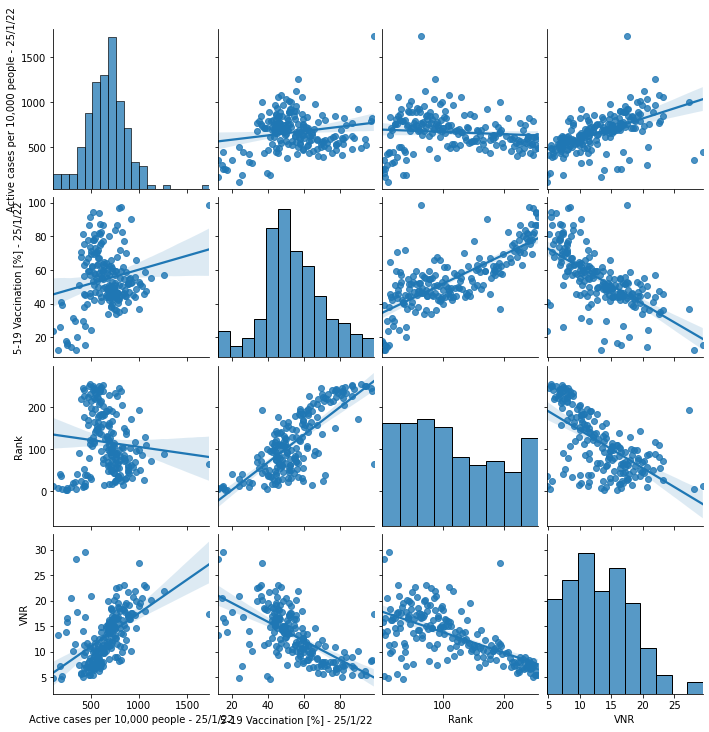

In [50]:
# save original keys for later
x_original = x_key
y_original = y_key

# Calc weights of cities by their relative 60+ population size
total_old_population = bubble_table["population_5-19"].sum()
w_key = "weight"
bubble_table[w_key] = (bubble_table["population_5-19"] / total_old_population) * 100

# 1) 60+ Vaccinations % ~ Cases per 10000
print("(1) - 5-19 Vaccinations % ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# 2) 60+ Vaccinations % ~ Socioeconomic Rank
x_key = "Rank"
print("(2) - 5-19 Vaccinations % ~ Socioeconomic Rank")
calc_correlations(x_key, y_key, w_key)

# 3) Socioeconomic Rank ~ Cases per 10000
x_key = x_original
y_key = "Rank"
print("(3) - Socioeconomic Rank ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# 4) Socioeconomic Rank ~ VNR
x_key = "VNR"
y_key = "Rank"
print("(4) - Socioeconomic Rank ~ {}".format(x_key.replace('_', ' ')))
calc_correlations(x_key, y_key, w_key)

# Correlogram
corr_table = bubble_table.copy()
corr_table = corr_table[[x_original, y_original, 'Rank', 'VNR']]
sns.pairplot(corr_table, kind="reg")
# plt.show()  # need to save manually to .png, .pdf, .svg after setting aspect ratio.

##### Save Results 

In [61]:
# # save to file
# plt.savefig('correlogram.png')
# plt.savefig('correlogram.pdf')
# plt.savefig('correlogram.svg')

# save raw data to csv
processed_data_save_path = os.path.join(PROJECT_PROCESSED_DATA_FOLDER, 'processed_data_merged.csv')
bubble_table.to_csv(processed_data_save_path, encoding='utf-8-sig', index=False)